In [92]:
# dependencies

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

import datetime

# postgres pull

db_password = "postgres"
db_user = "postgres"
db_name = "Youtube P3"
endpoint = 'youtube.cb1bticre0py.us-east-1.rds.amazonaws.com'

connection_string = f"postgresql://{db_user}:{db_password}@{endpoint}:5432/{db_name}"
engine = create_engine(connection_string)

og_data = pd.read_sql('SELECT * FROM all_data;', con = engine)

In [93]:
all_data = og_data

In [94]:
# initial quick cleanup


# turn user engagement nulls to medians
all_data[['view_count', 'likes','dislikes', 'comment_count']]=all_data[['view_count', 'likes','dislikes', 'comment_count']].replace(0,all_data[['view_count', 'likes','dislikes', 'comment_count']].median())


# changed publish_date & trending_date to datetime format
#all_data[["publishedat", "trending_date"]] = all_data[["publishedat", "trending_date"]].apply(pd.to_datetime)

# remove video_id's == '#NAME?'   (about 1,300 records)
all_data.drop(all_data[all_data.video_id == '#NAME?'].index, inplace=True)

# sort (important for the drop_duplicates later on)
all_data.sort_values('trending_date', inplace = True)

# clean given column names
all_data.rename(columns={'publishedat': 'publish_date', 
                         'channelid': 'channel_id', 
                         'channeltitle': 'channel_title', 
                         'likes':'likes_count', 
                         'dislikes': 'dislikes_count', 
                         'cat_codes': 'category'
                        }, inplace=True)

all_data.reset_index(inplace=True)
print(all_data.shape)
print('')
print(all_data.columns)
print('')
print(all_data.dtypes)
print(' ')
all_data.head(2)

(1298907, 13)

Index(['index', 'video_id', 'publish_date', 'channel_id', 'channel_title',
       'trending_date', 'view_count', 'likes_count', 'dislikes_count',
       'comment_count', 'thumbnail_link', 'country', 'category'],
      dtype='object')

index               int64
video_id           object
publish_date       object
channel_id         object
channel_title      object
trending_date      object
view_count        float64
likes_count       float64
dislikes_count    float64
comment_count     float64
thumbnail_link     object
country            object
category           object
dtype: object
 


,index,video_id,publish_date,channel_id,channel_title,trending_date,view_count,likes_count,dislikes_count,comment_count,thumbnail_link,country,category
0,1124587,cOeOtH4DY0g,2020-08-08,UCuOwl-VgqBHOzR8hWnonBcA,Sky Sport HD,2020-08-12,2353226.0,34427.0,1122.0,2108.0,https://i.ytimg.com/vi/cOeOtH4DY0g/default.jpg,Mexico,Sports
1,1005418,TsOU7Op7sTY,2020-08-08,UCsmXiDP8S40uBeJYxvyulmA,JO1,2020-08-12,165072.0,10105.0,67.0,1491.0,https://i.ytimg.com/vi/TsOU7Op7sTY/default.jpg,Japan,Music


In [95]:
## BEGIN FEATURE ENGINEERING

# add column 'combined_trend_days'

temp_df = all_data.groupby('video_id')['trending_date'].count().reset_index()
temp_df.rename({'trending_date':'combined_trend_days'}, axis = 'columns', inplace = True)
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')

# changed publish_date & trending_date to datetime format
all_data[["publish_date", "trending_date"]] = all_data[["publish_date", "trending_date"]].apply(pd.to_datetime)

# add columns 'day_of_week' and 'number_of_day'

all_data['publish_day'] = all_data['publish_date'].dt.day_name()
all_data['publish_day_num'] = all_data['publish_date'].dt.day_of_week

# add column 'publish_to_trend'

all_data['publish_to_trend'] = (all_data['trending_date'] - all_data['publish_date']).dt.days.astype(float)
# freq = 'D'
# date = all_data['trending_date']
# all_data['trend_days'] = date + pd.Timedelta(1, unit=freq) 

# add columns user-interactions ratios (likes per view & comments per view)

all_data['likes_ratio'] = round(all_data['likes_count'] / all_data['view_count']*100,2)
all_data['comments_ratio'] = round(all_data['comment_count'] / all_data['view_count']*100,2)

# add columns 'trend_days'

temp_df = all_data.groupby('video_id')['trending_date'].max()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'trending_date_y':'trending_date_max'}, axis = 'columns', inplace = True)
all_data.rename({'trending_date_x':'trending_date'}, axis = 'columns', inplace = True)
temp_df = all_data.groupby('video_id')['trending_date'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'trending_date_y':'trending_date_min'}, axis = 'columns', inplace = True)
all_data.rename({'trending_date_x':'trending_date'}, axis = 'columns', inplace = True)
# all_data['trend_days'] = (all_data['trending_date_max'] - all_data['trending_date']).dt.days.astype(float)
all_data['trend_days'] = ((all_data['trending_date'] - all_data['trending_date_min']).dt.days.astype(float))+1

# freq = 'D'
# date = all_data['trending_date']
# all_data['trend_days'] = date + pd.Timedelta(1, unit=freq)

In [48]:
# all_data.rename({'trending_date_y':'trending_date_max'}, axis = 'columns', inplace = True)
# all_data.rename({'trending_date_x':'trending_date'}, axis = 'columns', inplace = True)
# all_data['trend_days'] = (all_data['trending_date_max'] - all_data['trending_date']).dt.days.astype(float)
# all_data['trend_days']

0          3.0
1          3.0
2          3.0
3          2.0
4          2.0
          ... 
1298902    0.0
1298903    0.0
1298904    0.0
1298905    0.0
1298906    0.0
Name: trend_days, Length: 1298907, dtype: float64

In [96]:
# PRE TRENDING

# add column 'pt_likes' and 'pt_likes_rate'

temp_df = all_data.groupby('video_id')['likes_count'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'likes_count_y':'pt_likes'}, axis = 'columns', inplace = True)
all_data.rename({'likes_count_x':'likes'}, axis = 'columns', inplace = True)
all_data['pt_likes_rate'] = round(all_data['pt_likes'] / all_data['publish_to_trend'],2)

# add column 'pt_dislikes' and 'pt_dislikes_rate'

temp_df = all_data.groupby('video_id')['dislikes_count'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'dislikes_count_y':'pt_dislikes'}, axis = 'columns', inplace = True)
all_data.rename({'dislikes_count_x':'dislikes'}, axis = 'columns', inplace = True)
all_data['pt_dislikes_rate'] = round(all_data['pt_dislikes'] / all_data['publish_to_trend'],2)

# add column 'pt_comments' & 'pt_comments_rate'

temp_df = all_data.groupby('video_id')['comment_count'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'comment_count_y':'pt_comments'}, axis = 'columns', inplace = True)
all_data.rename({'comment_count_x':'comments'}, axis = 'columns', inplace = True)
all_data['pt_comments_rate'] = round(all_data['pt_comments'] / all_data['publish_to_trend'],2)

# add column 'pt_views' & 'pt_views_rate'

temp_df = all_data.groupby('video_id')['view_count'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'view_count_y':'pt_views'}, axis = 'columns', inplace = True)
all_data.rename({'view_count_x':'views'}, axis = 'columns', inplace = True)
all_data['pt_views_rate'] = round(all_data['pt_views'] / all_data['publish_to_trend'],2)

In [97]:
# WHILE TRENDING

# add column 'wt_likes'

##### temporary column for first trending day likes
temp_df = all_data.groupby('video_id')['likes'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'likes_y':'min_likes_count'}, axis = 'columns', inplace = True)
all_data.rename({'likes_x':'likes'}, axis = 'columns', inplace = True)
##### temporary column for last trending day likes
temp_df = all_data.groupby('video_id')['likes'].max()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'likes_y':'max_likes_count'}, axis = 'columns', inplace = True)
all_data.rename({'likes_x':'likes'}, axis = 'columns', inplace = True)
##### subtract min from max to get final column
all_data['wt_likes'] = all_data['max_likes_count'] - all_data['min_likes_count']
all_data.drop(columns = ['min_likes_count', 'max_likes_count'], inplace=True)

# add column 'wt_likes_rate'

#all_data["tempCol"] = all_data["trend_days"] / datetime.timedelta(days=1)
all_data['wt_likes_rate'] = round(all_data['wt_likes'] / all_data['trend_days'],2)
#all_data.drop(columns='tempCol')

# add column 'wt_dislikes'

##### temporary column for min dislikes count
temp_df = all_data.groupby('video_id')['dislikes'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'dislikes_y':'min_dislikes_count'}, axis = 'columns', inplace = True)
all_data.rename({'dislikes_x':'dislikes'}, axis = 'columns', inplace = True)
##### temporary column for max dislikes count
temp_df = all_data.groupby('video_id')['dislikes'].max()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'dislikes_y':'max_dislikes_count'}, axis = 'columns', inplace = True)
all_data.rename({'dislikes_x':'dislikes'}, axis = 'columns', inplace = True)
##### subtract min from max to get final column
all_data['wt_dislikes'] = all_data['max_dislikes_count'] - all_data['min_dislikes_count']
all_data.drop(columns = ['min_dislikes_count', 'max_dislikes_count'], inplace=True)

# add column 'wt_dislikes_rate'

#all_data["tempCol"] = all_data["trend_days"] / datetime.timedelta(days=1)
all_data['wt_dislikes_rate'] = round(all_data['wt_dislikes'] / all_data['trend_days'],2)
#all_data.drop(columns='tempCol')

# add column 'wt_comments'

##### temporary column for min comment count
temp_df = all_data.groupby('video_id')['comments'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'comments_y':'min_comment_count'}, axis = 'columns', inplace = True)
all_data.rename({'comments_x':'comments'}, axis = 'columns', inplace = True)
##### temporary column for max comment count
temp_df = all_data.groupby('video_id')['comments'].max()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'comments_y':'max_comment_count'}, axis = 'columns', inplace = True)
all_data.rename({'comments_x':'comments'}, axis = 'columns', inplace = True)
##### subtract min from max to get final column
all_data['wt_comments'] = all_data['max_comment_count'] - all_data['min_comment_count']
all_data.drop(columns = ['min_comment_count', 'max_comment_count'], inplace=True)

# add column 'wt_comments_rate'

#all_data["tempCol"] = all_data["trend_days"] / datetime.timedelta(days=1)
all_data['wt_comments_rate'] = round(all_data['wt_comments'] / all_data['trend_days'],2)
#all_data.drop(columns='tempCol', inplace=True)

# # add column 'wt_views'

##### temporary column for min view_count
temp_df = all_data.groupby('video_id')['views'].min()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'views_y':'min_view_count'}, axis = 'columns', inplace = True)
all_data.rename({'views_x':'views'}, axis = 'columns', inplace = True)
##### temporary column for max view_count
temp_df = all_data.groupby('video_id')['views'].max()
all_data = all_data.merge(temp_df, on = 'video_id', how = 'inner')
all_data.rename({'views_y':'max_view_count'}, axis = 'columns', inplace = True)
all_data.rename({'views_x':'views'}, axis = 'columns', inplace = True)
##### subtract min from max to get final column
all_data['wt_views'] = all_data['max_view_count'] - all_data['min_view_count']
all_data.drop(columns = ['min_view_count', 'max_view_count'], inplace=True)

# add column 'wt_views_rate'

#all_data["tempCol"] = all_data["trend_days"] / datetime.timedelta(days=1)
all_data['wt_views_rate'] = round(all_data['wt_views'] / all_data['trend_days'],2)
#all_data.drop(columns='tempCol', inplace=True)

In [98]:
# re-organize columns

all_data = all_data[[
                     'video_id', 
                     'category', 
                     'publish_date',
                     'trending_date',
                     'publish_to_trend', 
                     'combined_trend_days', 
                     'trend_days', 
                     'views',
                     'pt_views',
                     'wt_views',
                     'pt_views_rate',
                     'wt_views_rate',
                     'likes',
                     'pt_likes',
                     'wt_likes',
                     'pt_likes_rate',
                     'wt_likes_rate',
                     'likes_ratio',
                     'dislikes',
                     'pt_dislikes',
                     'wt_dislikes',
                     'pt_dislikes_rate',
                     'wt_dislikes_rate',
                     'comments',
                     'pt_comments',
                     'wt_comments',
                     'pt_comments_rate',
                     'wt_comments_rate',
                     'comments_ratio']]

In [99]:
all_data.reset_index()
print(all_data.shape)
print('')
print(all_data.columns)
print('')
print(all_data.dtypes)
print(' ')
all_data.head(2)

(1298907, 29)

Index(['video_id', 'category', 'publish_date', 'trending_date',
       'publish_to_trend', 'combined_trend_days', 'trend_days', 'views',
       'pt_views', 'wt_views', 'pt_views_rate', 'wt_views_rate', 'likes',
       'pt_likes', 'wt_likes', 'pt_likes_rate', 'wt_likes_rate', 'likes_ratio',
       'dislikes', 'pt_dislikes', 'wt_dislikes', 'pt_dislikes_rate',
       'wt_dislikes_rate', 'comments', 'pt_comments', 'wt_comments',
       'pt_comments_rate', 'wt_comments_rate', 'comments_ratio'],
      dtype='object')

video_id                       object
category                       object
publish_date           datetime64[ns]
trending_date          datetime64[ns]
publish_to_trend              float64
combined_trend_days             int64
trend_days                    float64
views                         float64
pt_views                      float64
wt_views                      float64
pt_views_rate                 float64
wt_views_rate                 float64
likes      

,video_id,category,publish_date,trending_date,publish_to_trend,combined_trend_days,trend_days,views,pt_views,wt_views,...,pt_dislikes,wt_dislikes,pt_dislikes_rate,wt_dislikes_rate,comments,pt_comments,wt_comments,pt_comments_rate,wt_comments_rate,comments_ratio
0,cOeOtH4DY0g,Sports,2020-08-08,2020-08-12,4.0,9,1.0,2353226.0,2353226.0,67000.0,...,1122.0,20.0,280.5,20.0,2108.0,2108.0,60.0,527.0,60.0,0.09
1,cOeOtH4DY0g,Sports,2020-08-08,2020-08-12,4.0,9,1.0,2353226.0,2353226.0,67000.0,...,1122.0,20.0,280.5,20.0,2108.0,2108.0,60.0,527.0,60.0,0.09


In [100]:
unique = all_data.drop_duplicates(subset='video_id', keep='last').reset_index(drop=True)

In [101]:
#unique.reset_index(drop=True)
print(unique.shape)
print('')
print(unique.columns)
print('')
print(unique.dtypes)
print(' ')
unique

(241112, 29)

Index(['video_id', 'category', 'publish_date', 'trending_date',
       'publish_to_trend', 'combined_trend_days', 'trend_days', 'views',
       'pt_views', 'wt_views', 'pt_views_rate', 'wt_views_rate', 'likes',
       'pt_likes', 'wt_likes', 'pt_likes_rate', 'wt_likes_rate', 'likes_ratio',
       'dislikes', 'pt_dislikes', 'wt_dislikes', 'pt_dislikes_rate',
       'wt_dislikes_rate', 'comments', 'pt_comments', 'wt_comments',
       'pt_comments_rate', 'wt_comments_rate', 'comments_ratio'],
      dtype='object')

video_id                       object
category                       object
publish_date           datetime64[ns]
trending_date          datetime64[ns]
publish_to_trend              float64
combined_trend_days             int64
trend_days                    float64
views                         float64
pt_views                      float64
wt_views                      float64
pt_views_rate                 float64
wt_views_rate                 float64
likes       

,video_id,category,publish_date,trending_date,publish_to_trend,combined_trend_days,trend_days,views,pt_views,wt_views,...,pt_dislikes,wt_dislikes,pt_dislikes_rate,wt_dislikes_rate,comments,pt_comments,wt_comments,pt_comments_rate,wt_comments_rate,comments_ratio
0,cOeOtH4DY0g,Sports,2020-08-08,2020-08-15,7.0,9,4.0,2420226.0,2353226.0,67000.0,...,1122.0,20.0,160.29,5.00,2168.0,2108.0,60.0,301.14,15.00,0.09
1,TsOU7Op7sTY,Music,2020-08-08,2020-08-14,6.0,3,3.0,171280.0,165072.0,6208.0,...,67.0,0.0,11.17,0.00,1501.0,1491.0,10.0,248.50,3.33,0.88
2,4yz7xqqG1rU,Entertainment,2020-08-07,2020-08-14,7.0,3,3.0,390991.0,375274.0,15717.0,...,442.0,12.0,63.14,4.00,531.0,527.0,4.0,75.29,1.33,0.14
3,qcMEMPEgLkg,Music,2020-08-07,2020-08-15,8.0,4,4.0,980653.0,878651.0,102002.0,...,308.0,0.0,38.50,0.00,29605.0,28575.0,1030.0,3571.88,257.50,3.02
4,1kfoxYRN6Rs,Autos & Vehicles,2020-08-07,2020-08-14,7.0,3,3.0,366379.0,329778.0,36601.0,...,125.0,14.0,17.86,4.67,617.0,585.0,32.0,83.57,10.67,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241107,f9F3taNqeic,Music,2022-03-25,2022-03-26,1.0,1,1.0,174723.0,174723.0,0.0,...,308.0,0.0,308.00,0.00,852.0,852.0,0.0,852.00,0.00,0.49
241108,U0PCnC0qI4M,Comedy,2022-03-24,2022-03-26,2.0,1,1.0,588455.0,588455.0,0.0,...,308.0,0.0,154.00,0.00,797.0,797.0,0.0,398.50,0.00,0.14
241109,1hn4I0drPMU,Sports,2022-03-25,2022-03-26,1.0,1,1.0,539097.0,539097.0,0.0,...,308.0,0.0,308.00,0.00,489.0,489.0,0.0,489.00,0.00,0.09
241110,Cxu_9QyywiI,Music,2022-03-25,2022-03-26,1.0,1,1.0,304049.0,304049.0,0.0,...,308.0,0.0,308.00,0.00,928.0,928.0,0.0,928.00,0.00,0.31


In [ ]:
##### create model target column, scale appropriate columns, remove appropriate columns, one-hot encode category

In [137]:
## find a target for classification models

temp = unique.groupby('video_id')['trend_days'].sum().sort_values(ascending=False)
target = pd.DataFrame(temp)
print(target[target.trend_days >9].count())
print(target[target.trend_days >8].count())
print(target[target.trend_days >7].count())
print(target[target.trend_days >6].count())
print(target[target.trend_days >5].count())
print(target[target.trend_days >4].count())
print(' ')

# add target column ### number entered here corresponds to graphs

unique['target'] = unique.trend_days > 5
unique['target'] = unique['target'].astype(int) # makes 1 or 0 for T or F

unique.head(10)

trend_days    11019
dtype: int64
trend_days    20508
dtype: int64
trend_days    34216
dtype: int64
trend_days    54410
dtype: int64
trend_days    81038
dtype: int64
trend_days    111492
dtype: int64
 


,video_id,category,publish_date,trending_date,publish_to_trend,combined_trend_days,trend_days,views,pt_views,wt_views,...,wt_dislikes,pt_dislikes_rate,wt_dislikes_rate,comments,pt_comments,wt_comments,pt_comments_rate,wt_comments_rate,comments_ratio,target
0,cOeOtH4DY0g,Sports,2020-08-08,2020-08-15,7.0,9,4.0,2420226.0,2353226.0,67000.0,...,20.0,160.29,5.00,2168.0,2108.0,60.0,301.14,15.00,0.09,0
1,TsOU7Op7sTY,Music,2020-08-08,2020-08-14,6.0,3,3.0,171280.0,165072.0,6208.0,...,0.0,11.17,0.00,1501.0,1491.0,10.0,248.50,3.33,0.88,0
2,4yz7xqqG1rU,Entertainment,2020-08-07,2020-08-14,7.0,3,3.0,390991.0,375274.0,15717.0,...,12.0,63.14,4.00,531.0,527.0,4.0,75.29,1.33,0.14,0
3,qcMEMPEgLkg,Music,2020-08-07,2020-08-15,8.0,4,4.0,980653.0,878651.0,102002.0,...,0.0,38.50,0.00,29605.0,28575.0,1030.0,3571.88,257.50,3.02,0
4,1kfoxYRN6Rs,Autos & Vehicles,2020-08-07,2020-08-14,7.0,3,3.0,366379.0,329778.0,36601.0,...,14.0,17.86,4.67,617.0,585.0,32.0,83.57,10.67,0.17,0
5,5WFp2_L4WVg,Film & Animation,2020-08-07,2020-08-14,7.0,3,3.0,1409749.0,1279914.0,129835.0,...,0.0,44.00,0.00,1483.0,1483.0,0.0,211.86,0.00,0.11,0
6,tExkJXjewWw,Howto & Style,2020-08-08,2020-08-14,6.0,3,3.0,135714.0,127560.0,8154.0,...,1.0,13.67,0.33,402.0,397.0,5.0,66.17,1.67,0.30,0
7,UxZE0AJcNlc,Entertainment,2020-08-07,2020-08-14,7.0,3,3.0,1804627.0,1775748.0,28879.0,...,31.0,444.86,10.33,2564.0,2526.0,38.0,360.86,12.67,0.14,0
8,yNppnTJ_GcU,Education,2020-08-12,2020-08-12,0.0,1,1.0,85672.0,85672.0,0.0,...,0.0,inf,0.00,717.0,717.0,0.0,inf,0.00,0.84,0
9,2cxzvjTeeuI,News & Politics,2020-08-11,2020-08-12,1.0,1,1.0,218164.0,218164.0,0.0,...,0.0,255.00,0.00,158.0,158.0,0.0,158.00,0.00,0.07,0


<AxesSubplot:>

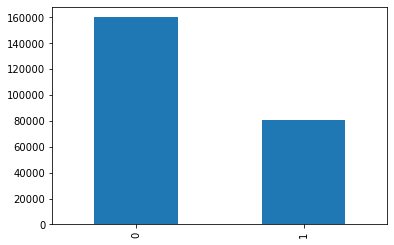

In [138]:
unique.target.value_counts().plot.bar()

1.0     43745
2.0     35482
5.0     30454
6.0     26628
4.0     26538
3.0     23855
7.0     20194
8.0     13708
9.0      9489
10.0     5709
11.0     2938
12.0     1346
13.0      596
14.0      245
15.0       87
16.0       47
17.0       19
22.0        5
18.0        5
29.0        3
21.0        3
37.0        2
24.0        2
25.0        2
36.0        2
26.0        2
31.0        2
30.0        1
19.0        1
23.0        1
33.0        1
Name: trend_days, dtype: int64

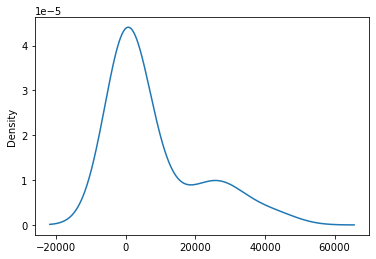

In [139]:
unique.trend_days.value_counts().plot.density()
unique.trend_days.value_counts()

In [ ]:
# label encode category column

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encoder = LabelEncoder()
unique['category'] = encoder.fit_transform(unique.category.values)

In [ ]:
slim_unique = unique.drop(columns=['trending_date_x', 'trending_days_by_country', 'video_id', 'publish_date', 'day_of_week', 'trending_date'])

In [ ]:
slimmer_unique = slim_unique[['publish_to_trend', 'category', 'while_trend_likes_count_temp','target']]

In [ ]:
slimmer_unique = slimmer_unique.fillna(1)

In [ ]:
slimmer_unique.shape

In [ ]:
# X = slim_unique.drop(columns = 'target').values

# y = slim_unique['target'].values

X = slimmer_unique.drop(columns = 'target').values

y = slimmer_unique['target'].values

print(X.shape)
print(y.shape)

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
import tensorflow as tf

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=4,
        step=2), activation=activation, input_dim=3))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 4)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=4,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [ ]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

In [ ]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

In [ ]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# # dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A','B']].to_numpy())

# slim_unique[
#             [
#             'trending_days',
#             'view_count', 
#             'views_while_trending',
#             'pretrend_view_count_temp', 
#             'while_trend_views_count_temp',
#             'likes_count', 
#             'likes_while_trending', 
#             'pretrend_likes_count_temp',
#             'while_trend_likes_count_temp',
#             'dislikes_count',
#             'dislikes_while_trending', 
#             'pretrend_dislikes_count_temp',
#             'while_trend_dislikes_count_temp', 
#             'comment_count',
#             'comments_while_trending', 
#             'pretrend_comment_count_temp',
#             'while_trend_comment_count_temp'
#             ]
#            ] = scaler.fit_transform(slim_unique[
#                                                 [
#                                                 'trending_days',
#                                                 'view_count', 
#                                                 'views_while_trending',
#                                                 'pretrend_view_count_temp', 
#                                                 'while_trend_views_count_temp',
#                                                 'likes_count', 
#                                                 'likes_while_trending', 
#                                                 'pretrend_likes_count_temp',
#                                                 'while_trend_likes_count_temp',
#                                                 'dislikes_count',
#                                                 'dislikes_while_trending', 
#                                                 'pretrend_dislikes_count_temp',
#                                                 'while_trend_dislikes_count_temp', 
#                                                 'comment_count',
#                                                 'comments_while_trending', 
#                                                 'pretrend_comment_count_temp',
#                                                 'while_trend_comment_count_temp'
#                                                 ]
#                                                ]
#                                    )
# slim_unique

In [ ]:
def test_model(model, data):
    X_train, X_test, y_train, y_test = data
    reg = model.fit(X_train, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train, y_train)}')
    print(f'Test Score: {reg.score(X_test, y_test)}\n')
    plt.show()   

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR

In [ ]:
data = [X_train, X_test, y_train, y_test]

In [ ]:
unique = unique.reset_index()

In [ ]:
test_model(LinearRegression(), data)
test_model(Lasso(max_iter=2000),data)
test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)